# Enhanced Fraud Detection Data Analysis

1. Import necessary libraries
2. Acquire and explore dataset
3. Clean and preprocess the data
4. Engineer new features 
5. Split the data into training and testing subsets
6. Select, implement, and compare various machine learning algorithms
7. Train the chosen models and optimize their hyperparameters
8. Evaluate the models using appropriate performance metrics

# Importing Necessary Libraries

In [38]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Data Loading, Understanding, and Cleaning

## Loading Train Data

In [39]:
# Loading train_transaction data
train_transaction = pd.read_csv('train_transaction.csv')
train_transaction.shape

(898, 394)

In [40]:
# Loading train_identity data
train_identity = pd.read_csv('train_identity.csv')
train_identity.shape

(16626, 41)

In [41]:
train_df = pd.merge(train_transaction, train_identity, how='left')
train_df.shape

(898, 434)

In [42]:
del train_transaction, train_identity

In [43]:
len_train_df = len(train_df)

## Loading Test Data

In [44]:
# Loading test data
test_transaction = pd.read_csv('test_transaction.csv')
test_transaction.shape

(2747, 393)

In [45]:
test_identity = pd.read_csv('test_identity.csv')
test_identity.shape

(28768, 41)

In [46]:
test_df = pd.merge(test_transaction, test_identity, how='left')
test_df.columns = train_df.drop('isFraud', axis=1).columns
test_df.shape

(2747, 433)

In [47]:
del test_transaction, test_identity

# Data Exploration

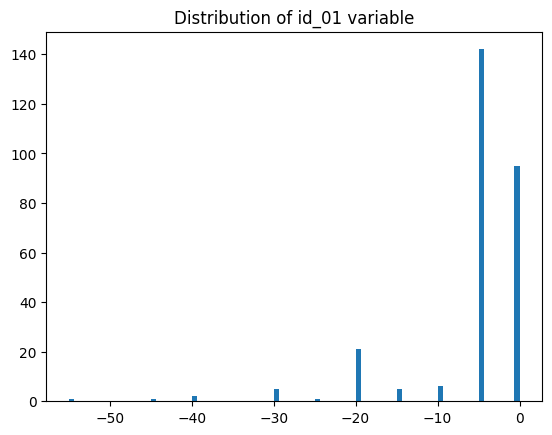

In [48]:
plt.hist(train_df['id_01'], bins=77);
plt.title('Distribution of id_01 variable');

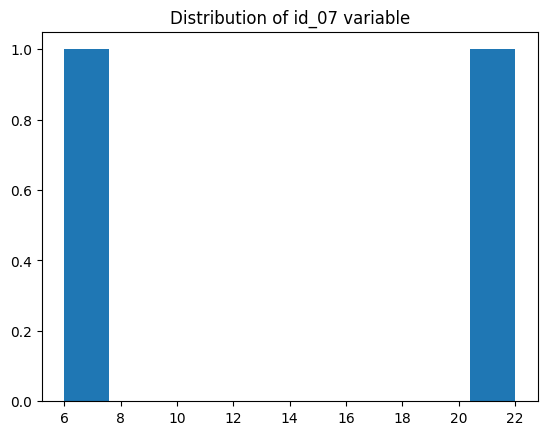

In [49]:
plt.hist(train_df['id_07']);
plt.title('Distribution of id_07 variable');

In [50]:
card_cols = [c for c in train_df.columns if 'card' in c]

In [51]:
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

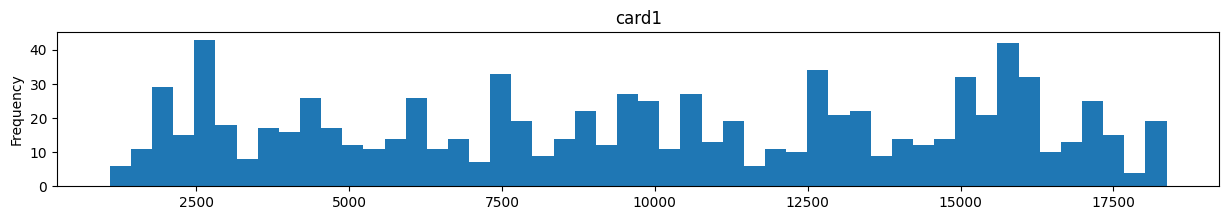

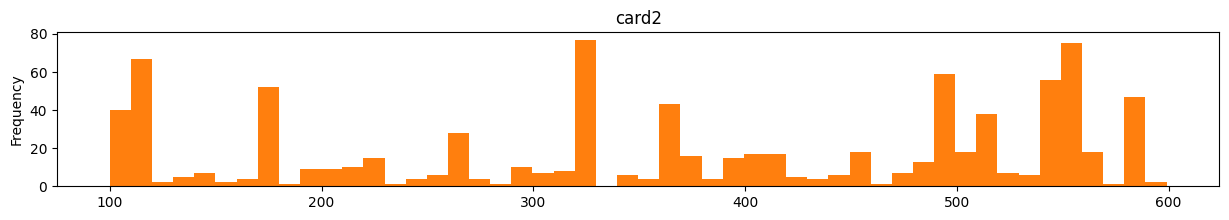

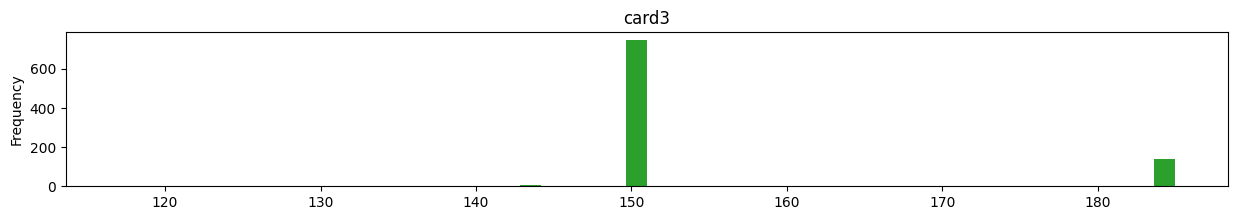

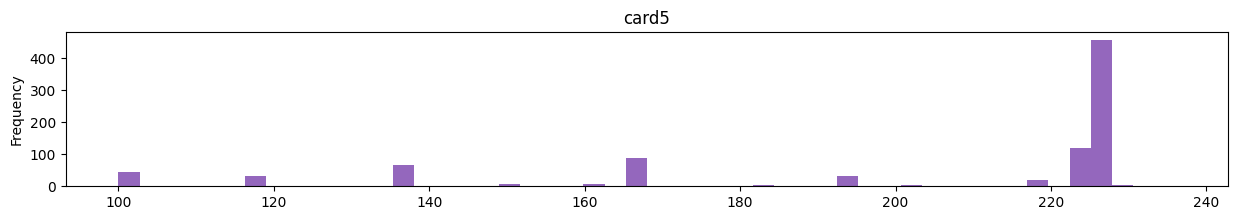

In [52]:
color_idx = 0
for c in card_cols:
    if train_df[c].dtype in ['float64','int64']:
        train_df[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

# Data Cleaning

In [53]:
# Duplicates check in train data
train_df.duplicated().sum()

0

This dataset has 434 columns, with the dependent variable being 'isFraud'. The dataset is split into two parts: the training data, which contains 590,540 samples, and the test data, which includes 506,691 records. We have verified that there are no duplicate entries in the dataset. Next, let's explore the distribution of the dependent variable, 'isFraud', to understand its characteristics better.

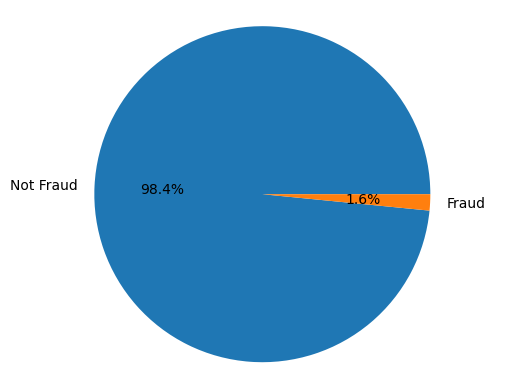

In [54]:
# Class imbalance check
plt.pie(train_df.isFraud.value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

As anticipated, this dataset presents a class imbalance issue. To address this, we will employ the Synthetic Minority Over-sampling Technique (SMOTE) in subsequent steps. But first, let's examine the distribution of the 'timestamp' column to gain further insights into the data.

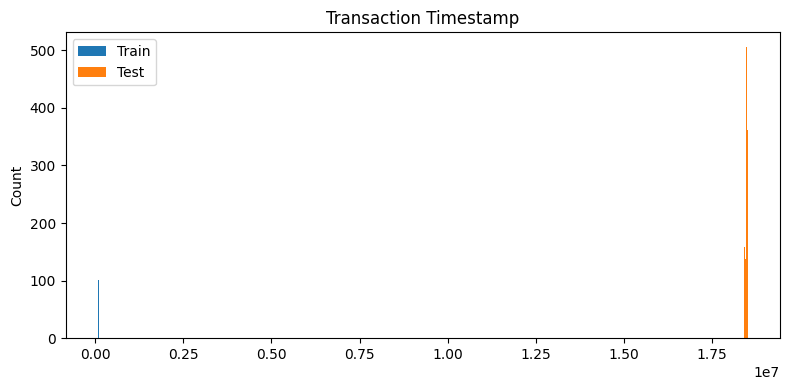

In [55]:
# Timestamp of train and test data
plt.figure(figsize=(8, 4))
plt.hist(train_df['TransactionDT'], label='Train')
plt.hist(test_df['TransactionDT'], label='Test')
plt.ylabel('Count')
plt.title('Transaction Timestamp')
plt.legend()
plt.tight_layout()
plt.show()

We observe that the test data's timestamp comes after the train data's timestamp. As a result, when training our machine learning model, it is crucial to use time-based splitting to generate appropriate training and validation sets. Before proceeding, let's address any missing values in the dataset.
A significant number of columns exhibit a high percentage of missing values. To mitigate this issue, we will only include columns with at least 80% available data, allowing for up to 20% of missing values that can be filled or imputed later on.

In [56]:
# Missing values check
combined_df = pd.concat([train_df.drop(columns=['isFraud', 'TransactionID']), test_df.drop(columns='TransactionID')])
print(combined_df.shape)

# Dependent variable
y = train_df['isFraud']
print(y.shape)

# Dropping columns with more than 20% missing values 
mv = combined_df.isnull().sum()/len(combined_df)
combined_mv_df = combined_df.drop(columns=mv[mv>0.2].index)
del combined_df, train_df, test_df
print(combined_mv_df.shape)

(3645, 432)
(898,)
(3645, 180)


After eliminating features with over 20% missing values, we are left with 180 columns out of the original 432. Additionally, we have removed the 'TransactionID' column, as it does not contribute to the prediction process. Next, let's address the remaining missing values. We will employ the median value for numerical columns, while for categorical columns, we will use the most frequent category to fill in any gaps.

In [57]:
# Filtering numerical data
num_mv_df = combined_mv_df.select_dtypes(include=np.number)
print(num_mv_df.shape)

# Filtering categorical data
cat_mv_df = combined_mv_df.select_dtypes(exclude=np.number)
print(cat_mv_df.shape)
del combined_mv_df

# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_mv_df), columns=num_mv_df.columns)
del num_mv_df
print(num_df.shape)

# Filling missing values by most frequent value for categorical columns
imp_max = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_df = pd.DataFrame(imp_max.fit_transform(cat_mv_df), columns=cat_mv_df.columns)
del cat_mv_df
print(cat_df.shape)

# Concatinating numerical and categorical data
combined_df_cleaned = pd.concat([num_df, cat_df], axis=1)
del num_df, cat_df

# Verifying missing values
print(f'Total missing values: {combined_df_cleaned.isnull().sum().sum()}')
print(combined_df_cleaned.shape)

(3645, 176)
(3645, 4)
(3645, 176)
(3645, 4)
Total missing values: 0
(3645, 180)


# Data Preprocessing

In [58]:
# One-hot encoding
combined_df_encoded = pd.get_dummies(combined_df_cleaned, drop_first=True)
print(combined_df_encoded.shape)
del combined_df_cleaned

(3645, 232)


In [59]:
# Separating train and test data
X = combined_df_encoded.iloc[:len_train_df]
print(X.shape)
test = combined_df_encoded.iloc[len_train_df:]
print(test.shape)
del combined_df_encoded

(898, 232)
(2747, 232)


In [60]:
# Time-based train validation splitting with 20% data in validation set
train = pd.concat([X, y], axis=1)
train.sort_values('TransactionDT', inplace=True)
X = train.drop(['isFraud'], axis=1)
y = train['isFraud']
splitting_index = int(0.8*len(X))
X_train = X.iloc[:splitting_index].values
X_val = X.iloc[splitting_index:].values
y_train = y.iloc[:splitting_index].values
y_val = y.iloc[splitting_index:].values
test = test.values
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del y, train

(718, 232) (180, 232) (718,) (180,)


In [61]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test)
del X_train, X_val, test

# Class imbalance check
pd.value_counts(y_train)

0    709
1      9
dtype: int64

# Pre SMOTE

## Random Forest Classifier

In [63]:
# Random Forest Classifier
rfc = RandomForestClassifier(criterion='entropy', max_features='sqrt', max_samples=0.5, min_samples_split=80)
rfc.fit(X_train_scaled, y_train)
y_predproba = rfc.predict_proba(X_val_scaled)

print(f'Validation AUC={roc_auc_score(y_val, y_predproba[:, 1])}')

y_pred = rfc.predict(X_val_scaled)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Validation AUC=0.7268571428571429
Accuracy: 0.9722222222222222
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       175
           1       0.00      0.00      0.00         5

    accuracy                           0.97       180
   macro avg       0.49      0.50      0.49       180
weighted avg       0.95      0.97      0.96       180



## Logisitc Regression

In [64]:
# Logistic Regression Classifier
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_scaled, y_train)

y_predproba = logistic_regression_model.predict_proba(X_val_scaled)
print(f'Validation AUC={roc_auc_score(y_val, y_predproba[:, 1])}')

y_pred = logistic_regression_model.predict(X_val_scaled)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Validation AUC=0.616
Accuracy: 0.9722222222222222
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       175
           1       0.00      0.00      0.00         5

    accuracy                           0.97       180
   macro avg       0.49      0.50      0.49       180
weighted avg       0.95      0.97      0.96       180



## XGBoost Classifier

In [65]:
# XGBoost Classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_scaled, y_train)

y_predproba = xgb_model.predict_proba(X_val_scaled)
print(f'Validation AUC={roc_auc_score(y_val, y_predproba[:, 1])}')

y_pred = xgb_model.predict(X_val_scaled)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Validation AUC=0.6182857142857143
Accuracy: 0.9722222222222222
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       175
           1       0.00      0.00      0.00         5

    accuracy                           0.97       180
   macro avg       0.49      0.50      0.49       180
weighted avg       0.95      0.97      0.96       180



# Post SMOTE

In [ ]:
# Applying SMOTE to deal with the class imbalance by oversampling
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(X_train_smote.shape, y_train_smote.shape)
del X_train_scaled, y_train
pd.value_counts(y_train_smote)

(6060, 236) (6060,)


0    3030
1    3030
dtype: int64

# ML Modeling

## Random Forest Classifier

In [ ]:
# Random Forest Classifier
rfc = RandomForestClassifier(criterion='entropy', max_features='sqrt', max_samples=0.5, min_samples_split=80)
rfc.fit(X_train_smote, y_train_smote)
y_predproba = rfc.predict_proba(X_val_scaled)

print(f'Validation AUC={roc_auc_score(y_val, y_predproba[:, 1])}')

y_pred = rfc.predict(X_val_scaled)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Validation AUC=0.8182186234817814
Accuracy: 0.9896507115135834
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       760
           1       1.00      0.38      0.56        13

    accuracy                           0.99       773
   macro avg       0.99      0.69      0.78       773
weighted avg       0.99      0.99      0.99       773



## Logisitc Regression

In [ ]:
# Logistic Regression Classifier
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_smote, y_train_smote)

y_predproba = logistic_regression_model.predict_proba(X_val_scaled)
print(f'Validation AUC={roc_auc_score(y_val, y_predproba[:, 1])}')

y_pred = logistic_regression_model.predict(X_val_scaled)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Validation AUC=0.7030364372469636
Accuracy: 0.7852522639068564
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88       760
           1       0.04      0.46      0.07        13

    accuracy                           0.79       773
   macro avg       0.51      0.63      0.47       773
weighted avg       0.97      0.79      0.87       773



## XGBoost Classifier

In [ ]:
# XGBoost Classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_smote, y_train_smote)

y_predproba = xgb_model.predict_proba(X_val_scaled)
print(f'Validation AUC={roc_auc_score(y_val, y_predproba[:, 1])}')

y_pred = xgb_model.predict(X_val_scaled)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Validation AUC=0.790080971659919
Accuracy: 0.9909443725743855
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       760
           1       1.00      0.46      0.63        13

    accuracy                           0.99       773
   macro avg       1.00      0.73      0.81       773
weighted avg       0.99      0.99      0.99       773



# Picking the Best Model

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

# Random Forest Classifier
rfc = RandomForestClassifier()

# Logistic Regression
logreg = LogisticRegression()

# XGBClassifier
xgb_clf = xgb.XGBClassifier()

# Define the parameter grids
param_dist_rfc = {
    'n_estimators': sp_randint(10, 200),
    'max_depth': sp_randint(1, 20),
    'min_samples_split': sp_randint(2, 50),
    'min_samples_leaf': sp_randint(1, 20),
    'max_features': ['sqrt', 'log2', None],
}

param_dist_logreg = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': uniform(0.001, 100),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500, 1000, 2000],
}

param_dist_xgb = {
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': sp_randint(1, 10),
    'min_child_weight': sp_randint(1, 10),
    'gamma': uniform(0, 0.2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'n_estimators': sp_randint(10, 200),
}

# Create the RandomizedSearchCV objects
random_search_rfc = RandomizedSearchCV(rfc, param_distributions=param_dist_rfc, n_iter = 5, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1, random_state=42)
random_search_logreg = RandomizedSearchCV(logreg, param_distributions=param_dist_logreg, n_iter = 5, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1, random_state=42)
random_search_xgb = RandomizedSearchCV(xgb_clf, param_distributions=param_dist_xgb, n_iter = 5, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV objects
random_search_rfc.fit(X_train_smote, y_train_smote)
random_search_logreg.fit(X_train_smote, y_train_smote)
random_search_xgb.fit(X_train_smote, y_train_smote)

# Compare the best scores
best_scores = {
    'RandomForest': random_search_rfc.best_score_,
    'LogisticRegression': random_search_logreg.best_score_,
    'XGBClassifier': random_search_xgb.best_score_,
}

best_model_name = max(best_scores, key=best_scores.get)

model_dict = {
    'RandomForest': random_search_rfc,
    'LogisticRegression': random_search_logreg,
    'XGBClassifier': random_search_xgb
}

best_model = model_dict[best_model_name]


print("Best model:", best_model_name)
print("Best score:", best_scores[best_model_name])

# Use the best estimator
best_estimator = best_model.best_estimator_

# Predict probabilities
y_predproba = best_estimator.predict_proba(X_val_scaled)

# Calculate the ROC AUC score
print(f'Validation AUC={roc_auc_score(y_val, y_predproba[:, 1])}')

# Make predictions
y_pred = best_estimator.predict(X_val_scaled)

# Calculate the accuracy
print("Accuracy:", accuracy_score(y_val, y_pred))

# Print the classification report
print("Classification Report:\n", classification_report(y_val, y_pred))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best model: XGBClassifier
Best score: 0.998750122537006
Validation AUC=0.8837044534412956
Accuracy: 0.9896507115135834
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       760
           1       0.86      0.46      0.60        13

    accuracy                           0.99       773
   macro avg       0.92      0.73      0.80       773
weighted avg       0.99      0.99      0.99       773



# Analyze the results by quartile

In [ ]:
import pandas as pd
import numpy as np

# Use the best_estimator to predict probabilities for the validation set
y_predproba = best_estimator.predict_proba(X_val_scaled)

# Extract the probabilities for the positive class (assuming it's the second column)
positive_probs = y_predproba[:, 1]

# Calculate quartiles for the predicted probabilities
quartiles = pd.qcut(positive_probs, q=4, labels=["Q1", "Q2", "Q3", "Q4"])

# Create a DataFrame with the true labels, predicted probabilities, and quartiles
results = pd.DataFrame({
    'true_labels': y_val,
    'predicted_probs': positive_probs,
    'quartiles': quartiles
})

# Analyze the results by quartile
results_by_quartile = results.groupby('quartiles').agg({
    'true_labels': ['count', 'sum'],
    'predicted_probs': ['mean']
})

results_by_quartile.columns = ['count', 'positive_count', 'mean_predicted_prob']
results_by_quartile.reset_index(inplace=True)

print(results_by_quartile)


  quartiles  count  positive_count  mean_predicted_prob
0        Q1    194               0             0.000408
1        Q2    193               1             0.001281
2        Q3    193               2             0.004005
3        Q4    193              10             0.063383
